In [19]:
from viresclient import set_token
from viresclient import SwarmRequest
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.animation as animation

from scipy import signal

from scipy import constants
import aacgmv2
import asilib
import asilib.asi
mu0 = constants.mu_0
from numpy.typing import NDArray
import mplcyberpunk
#plt.style.use("cyberpunk")

In [20]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=25):
    return butter(order, cutoff, fs=fs, btype="low", analog=False)


def butter_lowpass_filter(data, cutoff, fs, order=25):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [21]:
def sinc_interpolation(x: NDArray, s: NDArray, u: NDArray) -> NDArray:
    """Whittaker–Shannon or sinc or bandlimited interpolation.
    Args:
        x (NDArray): signal to be interpolated, can be 1D or 2D
        s (NDArray): time points of x (*s* for *samples*)
        u (NDArray): time points of y (*u* for *upsampled*)
    Returns:
        NDArray: interpolated signal at time points *u*
    Reference:
        This code is based on https://gist.github.com/endolith/1297227
        and the comments therein.
    TODO:
        * implement FFT based interpolation for speed up
    """
    sinc_ = np.sinc((u - s[:, None]) / (s[1] - s[0]))

    return np.dot(x, sinc_)

In [22]:
set_token(
    "https://vires.services/ows",
    set_default=True,
    token="kmxv5mTTyYwzw4kQ9lsCkGfQHtjjJRVZ",
)  # key


Token saved for https://vires.services/ows


In [23]:
def numpy_conditioning(array):
    print(len(array))
    array_returned = np.zeros((len(array), 3))
    for i in range(len(array)):
        for j in range(3):
            array_returned[i] = array[i]
    return array_returned

In [24]:
base = datetime(2021,9, 24, 3, 46)
date_list_B = [base + timedelta(seconds=x) for x in range(132)]

In [25]:
def moving_average(a,length): #https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    n = int(len(a)*length/(date_list_B[-1]-date_list_B[0]).total_seconds())  # gives length second averaging
    y_padded = np.pad(a, (n//2, n-1-n//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((n,))/n, mode='valid')
    return y_smooth

In [26]:
Magnetic_products = "SW_OPER_MAGA_HR_1B"

request = SwarmRequest()
request.set_collection(Magnetic_products)
request.set_products(
    measurements=["B_NEC", "Flags_B"],
    models=["CHAOS"],
    residuals=False,  # grabs residual from chaos
)
data = request.get_between(
    start_time=date_list_B[0] - timedelta(seconds=5),
    end_time=date_list_B[-1] + timedelta(seconds=5),
    asynchronous=False,
)
# changes data into a dataframe format, which is easy to use
df_b = data.as_dataframe()
time_b_B=df_b.index.to_pydatetime()
B_NEC = numpy_conditioning(df_b["B_NEC"].to_numpy()) * 10 ** (-9)
B_CHAOS = numpy_conditioning(df_b["B_NEC_CHAOS"].to_numpy()) * 10 ** (-9)
B_RES_B = B_NEC - B_CHAOS
Electric_products = "SW_EXPT_EFIA_TCT16"

request = SwarmRequest()
request.set_collection(Electric_products)
request.set_products(
    measurements=[
        "Ehx",
        "Ehy",
        "Ehz",
        "VsatN",
        "VsatE",
        "VsatC",
        "Calibration_flags",
        "Quality_flags",
    ],
)
data = request.get_between(
    start_time=date_list_B[0] - timedelta(seconds=5),
    end_time=date_list_B[-1] + timedelta(seconds=5),
    asynchronous=False,
)
# changes data into a dataframe format, which is easy to use
df_E = data.as_dataframe()
print(df_E)
time_e_B=df_E.index.to_pydatetime()
# E derived from the horizontal sensor
E_data_numpy = df_E[["Ehx", "Ehy", "Ehz"]].to_numpy() * 0.001
V_data_numpy = df_E[["VsatN", "VsatE", "VsatC"]].to_numpy()
E_data = numpy_conditioning(E_data_numpy)
Velocity = numpy_conditioning(E_data_numpy)
VelocitySum = np.abs(Velocity).sum(axis=1)

Velocity_Unit = Velocity / VelocitySum[:, np.newaxis]
ElectricNEC_B = np.multiply(Velocity_Unit, E_data)
B_RES_resample_B = np.empty((len(ElectricNEC_B), 3))
B_RES_sinc_B = np.empty((len(ElectricNEC_B), 3))
lat_satellite_not_footprint = df_b["Latitude"].to_numpy()
lon_satellite_not_footprint = df_b["Longitude"].to_numpy()
altitude = df_b["Radius"].to_numpy() / 1000 - 6378.1370

# conjunction_obj = asilib.Conjunction(asi, (df_b.to_numpy(), np.array([lat_satellite_not_footprint, lon_satellite_not_footprint, altitude]).T))

# Converts altitude to assumed auroral height
helper = np.vectorize(lambda x: x.timestamp())
# foot_print_coord=conjunction_obj.lla_footprint(alt=110)
lat_B,long,alt=aacgmv2.convert_latlon_arr(lat_satellite_not_footprint,lon_satellite_not_footprint,altitude,base,"G2A")
print(time_e_B)


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.586MB)

7050
7050


Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.139MB)

                                     Ehy  Longitude        VsatN        Ehx  \
Timestamp                                                                     
2021-09-24 03:45:55.006750208   0.967185 -94.466438  7635.201172   4.090539   
2021-09-24 03:45:55.068749824  -0.325470 -94.466209  7635.197266  13.720494   
2021-09-24 03:45:55.131750144  -2.185583 -94.465973  7635.193359   5.784692   
2021-09-24 03:45:55.193750016   1.826070 -94.465744  7635.189453  -1.079552   
2021-09-24 03:45:55.256750080  -2.403278 -94.465515  7635.185059   9.142824   
...                                  ...        ...          ...        ...   
2021-09-24 03:48:15.693750016  12.292206 -93.650116  7621.615723 -26.407551   
2021-09-24 03:48:15.756750080  13.544007 -93.649582  7621.606445 -23.810583   
2021-09-24 03:48:15.818749952  17.126053 -93.649048  7621.597656 -19.011997   
2021-09-24 03:48:15.881750016  18.022593 -93.648506  7621.588379 -14.042312   
2021-09-24 03:48:15.943749888  13.190529 -93.647972 

In [27]:
for i in range(len(df_E['Quality_flags'])):
    print(df_E['Quality_flags'][i])

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [28]:
for i in range(len(df_E['Calibration_flags'])):
    print(df_E['Calibration_flags'][i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [29]:
#intialize filter
b,a = butter_lowpass(7.5,50, 20) #https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

In [30]:
B_not_averaged=np.array(B_RES_B[:,1])
for i in range(3):
    ElectricNEC_B[:, i] = ElectricNEC_B[:, i] - moving_average(ElectricNEC_B[:, i], 20)
for i in range(3):
    B_RES_B[:, i] = B_RES_B[:, i] - moving_average(B_RES_B[:, i], 20)
for i in range(3):
    B_RES_B[:, i] = signal.filtfilt(a=a,b=b,x=B_RES_B[:, i])
for i in range(3):
    B_RES_resample_B[:, i] = signal.resample(B_RES_B[:, i], len(ElectricNEC_B[:, 0]))
for i in range(3):
    B_RES_sinc_B[:, i] = sinc_interpolation(B_RES_B[:, i], helper(time_b_B), helper(time_e_B))

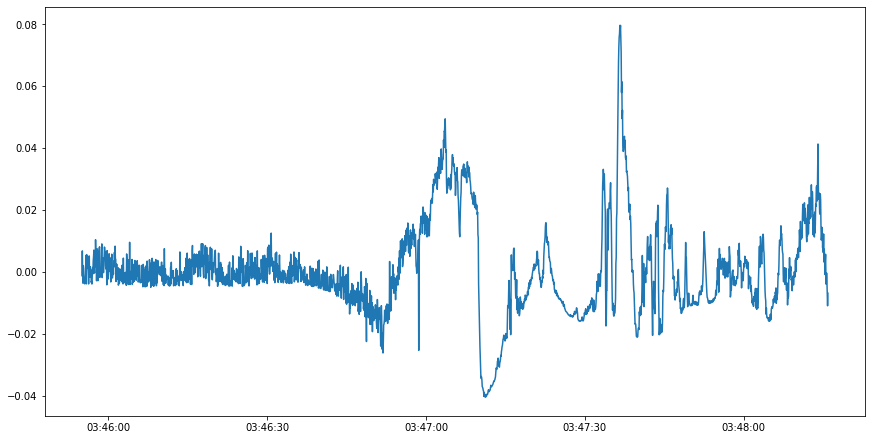

In [31]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
plt.plot(time_e_B, ElectricNEC_B[:, 0])

In [32]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
plt.plot(lat_B,B_RES_B[:,1], label='B')
plt.legend()

In [ ]:
for i in range(len(df_E['Quality_flags'])):
    print(df_E['Quality_flags'][i])

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [ ]:
for i in range(len(df_E['Calibration_flags'])):
    print(df_E['Calibration_flags'][i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD

In [ ]:
print(len(time_e_B) , len(B_RES_sinc_B[:,1]))

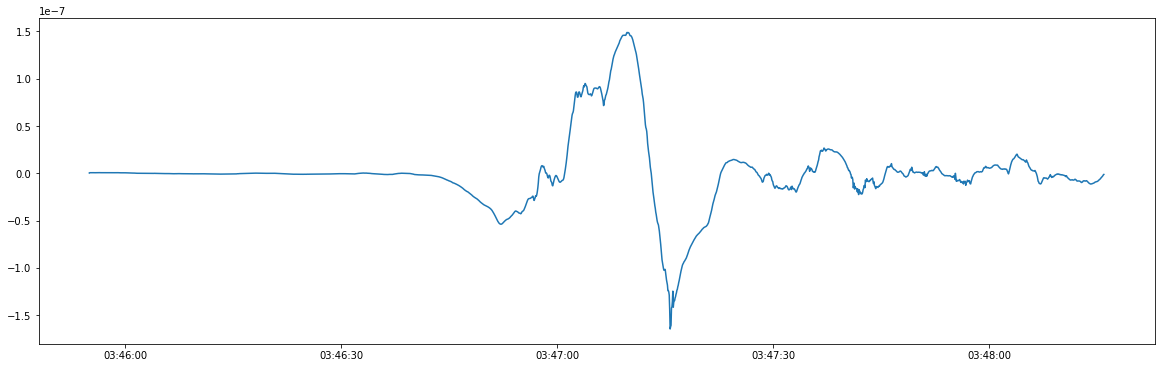

ValueError: x and y must have same first dimension, but have shapes (2256,) and (7050,)

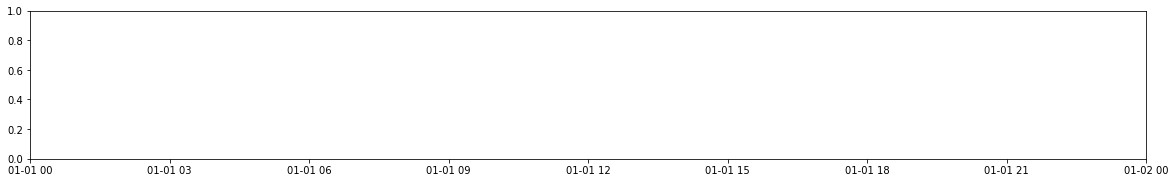

In [ ]:
emd = EMD()
imfs = emd(B_RES_B[:,1])
plt.figure(figsize=(20, 6))
plt.plot(time_e_B,B_RES_sinc_B[:,1])
plt.show()
plt.close()
plt.figure(figsize=(20, 6))
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs), 1, i + 1)
    plt.plot(time_e_B, imf)
    plt.title(f'IMF {i + 1}')
plt.tight_layout()
plt.show()